# Day 5 - Galaxy Classification Using Convolutional Neural Networks

In today's Day 5 tutorial you will be working through an example in which we will be classifying the morphology (i.e. the physical shape) of galaxies in the Sloan Digital Sky Survey (SDSS) using a convolutional neural network named GaMorNet.

Note: The procedural portion of this tutorial is largely based on the GaMorNet tutorials available as part of the GaMorNet documentation (https://gamornet.readthedocs.io/en/latest/tutorials.html). All mentions of "the paper" in this tutorial, refer to [Ghosh et. al. (2020)](https://iopscience.iop.org/article/10.3847/1538-4357/ab8a47)


## Introduction

Galaxies in the Universe can take on a wide variety of shapes and sizes. Galaxy morphological classification, or classifying galaxies by their shape and visual appearance, is a system used by astronomers to divide galaxies into groups. Early observations of a few hundred nearby, bright galaxies by Edwin Hubble in the 1920s led to the development of what is known as the “Hubble Sequence”, a classification scheme that identifies three main morphological types: spirals, lenticulars, and ellipticals (Hubble 1926; Sandage 1961). Although galaxies can be classified by eye, the advent of large astronomical surveys such as the SDSS has ushered in an era of big datasets and modern efforts to classify galaxies by shape largely use computational methods.

### The Shape of Galaxies in the Universe

<img src="imgs/main_image_deep_field_smacs0723-5mb.jpg" alt="Alternative text" />

The above image was recently produced by the James Webb Space Telescope (JWST; NASA). This first Deep Field image features galaxy cluster SMACS 0723, and it is teeming with thousands of galaxies – including the faintest objects ever observed at infrared wavelengths. JWST’s image took roughly 12.5 hrs of telescope time to create and covers a tiny patch of sky (approximately the size of a grain of sand held at arm’s length by someone on the ground) and reveals thousands of galaxies of all shapes and sizes in just a sliver of the vast universe. This image is an excellent example of the wonderfully diverse spectrum of galaxy morphology in the Universe.

### `GaMorNet`

In the tutorial below we will be using The Galaxy Morphology Network (GaMorNet). GaMorNet is a convolutional neural network that can classify galaxies as being "disk-like", "elliptical-like" or "indeterminate" based on how light is distributed within the galaxy. The advantage of GaMorNet is that it doesn’t need a large amount of training data to provide reliable predictions and can work across different types of data sets.

Although GaMorNet is a far more sophisticated neural network than the simple example we developed to classify flowers, the basic principles remain the same. Here, GaMorNet assesses galaxy shapes by using physically relevant property of their **bulge-to-total** luminosity ratio. 

 - Galaxies with light mainly distributed in disk structures are said to be **disk-dominated**. This is the case in, for example, spiral galaxies like our own Milky Way.

- Galaxies with light primarily in large, round bulge structures are said to be **bulge-dominated**. Examples of this include massive elliptical galaxies like Messier 87 (also known as Virgo A or NGC 4486).

- Galaxies where it's not entirely clear which component dominates (or in cases where the algorithm is unable to make a classification are said to be **indeterminate**.

<img src="imgs/galaxyzoo_spiral_elliptical.jpeg" alt="Alternative text" />

The above image shows an example of disk vs. elliptical type galaxy.

GaMorNet assesses the distribution of light within each galaxy in an image and reports back a likelihood prediction that the galaxy is bulge-dominated, disk-dominated, or indeterminate. Because of this, each galaxy receives *three* likelihood predictions, which each range between 0 and 1.

### Running `GaMorNet` in Google Colab

Although this tutorial can be run on any machine which has GaMorNet installed, it's pretty handy to run this on Google Colab as you can easily use Colab's GPUs for this tutorial.

Note that with the free version of CoLab, you will only have access to a limited amount of memory. Thus, the number of images we use here for training/testing our network is very small in comparison to how many would be used in astronomy research. In reality, GaMorNet can handle hundreds of thousands of images! 

This first section is meant to be run only when following this tutorial in Google Colab.

### Make things Fast!

Before we dive in, let's make sure we're using a Google CoLab GPU for this tutorial.  

To do this, go to the menus at the top and select "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "GPU".

### Installing Libraries Needed for this Tutorial

Let's first begin by using some *pip* commands to install some required libraries.

In [8]:
!pip install matplotlib
!pip install astropy
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Install GaMorNet

Next, let's install the GaMorNet software.

In [9]:
import os
# Suppressing TF warnings and info for a cleaner environ
# Set this to 0,1 for info and warnings respectively.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
 
# Magic telling Colab we want TF version ~=1.0
%tensorflow_version 1.x

!pip install -q --upgrade gamornet

In [10]:
##Checking which version of Tensorflow & GaMorNet is being used and whether the installation worked.
import tensorflow as tf
import gamornet
print(tf.__version__)
print(gamornet.__version__)
from gamornet.keras_module import gamornet_train_keras, gamornet_tl_keras, gamornet_predict_keras
from gamornet.tflearn_module import gamornet_train_tflearn, gamornet_tl_tflearn, gamornet_predict_tflearn

1.15.2
0.4.3



The following snippet will verify that we have access to a GPU.

In [11]:
#Checking access to GPU
import tensorflow as tf
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Training with `GaMorNet`

GaMorNet can quite easily be trained from scratch using images. 

In this demonstration, we will use 90 *simulated* SDSS images for the purposes of training and 10 *simulated* SDSS images for validation. All these simulated images come from the set of simulated galaxies created for the paper referenced above. Note: these are not images of actual galaxies. They have been created using software to mimic the wide variety of galaxies observed in the wild.

All these images contain disk + bulge components. As described in the paper, Ghosh et al. (2020) has also convolved these simulations with a representative point-spread-function and added representative noise to better mimic actual scientific data. 

### Downloading the Data

First, let's download the images that we are going to use to train GaMorNet. We will download these into the local filesystem from Yale Astronomy's FTP service, where these are hosted.

We are going to download all the 100 images (90+10) as a single archive and then export it to a single folder called `training_imgs`. The images are in the FITS format and are named `output_img_xx.fits` where xx runs from 0 to 99.

We are also going to download the `sim_para.txt` file containing the ground-truth parameters for the above galaxies. Using these values, we are going to calculate the bulge-to-total light ratio of each galaxy and determine the labels to be used during the training process. 


*Tip: The `%%bash` command lets Colab know that all the commands in this shell needs to be passed the local unix virtual environment.*

*Tip: To view the files in use on Colab, click the folder icon on the left sidebar.*

In [12]:
%%bash
#get zip and txt file from server
wget ftp://ftp.astro.yale.edu/pub/aghosh/gamornet_tutorial_files/train_images/training_imgs.tar.gz
wget ftp://ftp.astro.yale.edu/pub/aghosh/gamornet_tutorial_files/train_images/sim_para.txt

#Unzip the Archive
tar -xvf training_imgs.tar.gz

./train_images/output_img_0.fits
./train_images/output_img_10.fits
./train_images/output_img_11.fits
./train_images/output_img_12.fits
./train_images/output_img_13.fits
./train_images/output_img_14.fits
./train_images/output_img_15.fits
./train_images/output_img_16.fits
./train_images/output_img_17.fits
./train_images/output_img_18.fits
./train_images/output_img_19.fits
./train_images/output_img_1.fits
./train_images/output_img_20.fits
./train_images/output_img_21.fits
./train_images/output_img_22.fits
./train_images/output_img_23.fits
./train_images/output_img_24.fits
./train_images/output_img_25.fits
./train_images/output_img_26.fits
./train_images/output_img_27.fits
./train_images/output_img_28.fits
./train_images/output_img_29.fits
./train_images/output_img_2.fits
./train_images/output_img_30.fits
./train_images/output_img_31.fits
./train_images/output_img_32.fits
./train_images/output_img_33.fits
./train_images/output_img_34.fits
./train_images/output_img_35.fits
./train_images/ou

--2022-07-13 23:17:12--  ftp://ftp.astro.yale.edu/pub/aghosh/gamornet_tutorial_files/train_images/training_imgs.tar.gz
           => ‘training_imgs.tar.gz.1’
Resolving ftp.astro.yale.edu (ftp.astro.yale.edu)... 128.36.139.12
Connecting to ftp.astro.yale.edu (ftp.astro.yale.edu)|128.36.139.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/aghosh/gamornet_tutorial_files/train_images ... done.
==> SIZE training_imgs.tar.gz ... 13849775
==> PASV ... done.    ==> RETR training_imgs.tar.gz ... done.
Length: 13849775 (13M) (unauthoritative)

     0K .......... .......... .......... .......... ..........  0%  110K 2m3s
    50K .......... .......... .......... .......... ..........  0%  219K 92s
   100K .......... .......... .......... .......... ..........  1%  202M 61s
   150K .......... .......... .......... .......... ..........  1%  214K 61s
   200K .......... .......... .......... .......... .........

In the cell below, write a code block which visualizes one of the training set FITS files.

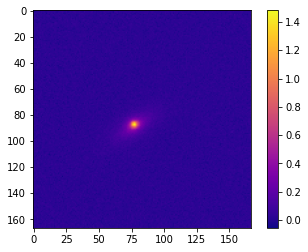

In [16]:
import numpy as np

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

image_file = "train_images/output_img_25.fits"
image_data = fits.getdata(image_file)

plt.imshow(image_data, cmap='plasma')
plt.colorbar()

***

#### Q - Iterate through visualizing some of the training data images. How well do they resemble real galaxies? Why might astronomers choose to use simulated images as training data?

***

Ans. Here

### Preparing the Data

In this section, we will generate the training and validation image arrays as well as the corresponding labels to be used during the networks' training process.


First, let's read in the `.txt` file and calculate the difference in disk and bulge magnitudes (i.e. brightnesses) for each of the galaxies.

In [17]:
import pylab as plt

#Let's read in the sim_para.txt file 
gal_para = plt.genfromtxt("./sim_para.txt",names=True,usecols = (4,11))
 
#difference b/w the integrated magnitude of the disk and bulge components. 
#The rows in the file and thus the elements in the array below correspond to
#the numbers in the names of the image files. (i.e. the 0th element corresponds
#to output_img_0.fits)
disk_bulge_mag = gal_para["Inte_Mag"] - gal_para["Inte_Mag_2"]

Next, let's define two convenience functions, which will assist us in creating the image and label arrays. The first reshapes each data array to add a third dimension. The second function adds a vector that acts as a label for which type of galaxy the array represents. This label is determined by using the magnitudes calculated in the cell above.

In [20]:
# Convenience Function to get and return images as numpy arrays

def image_handler(i):
  return np.reshape(fits.getdata("./train_images/output_img_"+str(i)+".fits",
                                 memmap=False),newshape=(167,167,1)) 
  #We use the reshape command just to add the extra 3rd dimension. The image is 
  #originally 167*167. So, in essence no re-sizing is taking place in the X or Y
  #directions.


# Convenience Function to get and return the training labels of each galaxy
# in the one-hot encoding format. i.e. disk-dominated galaxies will be represented
# by the array [1,0,0], bulge-dominated by [0,0,1] and indeterminate by [0,1,0]

def label_handler(i):
  
  target_vect = [0]*3

  if (disk_bulge_mag[i] < -0.22): #  (Lb/LT) < 0.45
    target_vect[0] = 1  #disk-dominated       
  
  elif ( -0.22 <=  disk_bulge_mag[i] <= 0.22):
      target_vect[1] = 1 #indeterminate
  
  else: #  (Lb/LT) > 0.55
      target_vect[2] = 1 #bulge-dominated

  return target_vect

Now, we are going to use the first 90 images to create the training set and the last 10 to create the validation set. We are multi-threading the process below -- although this is an absolute overkill for 100 images, it's very handy while dealing with large numbers of images. 

In [21]:
from multiprocessing import Pool
import numpy as np
from astropy.io import fits

NUM_THREADS = 2

pl = Pool(NUM_THREADS)
training_imgs = np.array(pl.map(image_handler,range(0,90)))
training_labels = np.array(pl.map(label_handler,range(0,90)))

valdiation_imgs = np.array(pl.map(image_handler,range(90,100)))
validation_labels = np.array(pl.map(label_handler,range(90,100)))

There are two modules available for training GaMorNet:

 - `Keres`
 - `TFLearn`

 These two models function somewhat similarly, and differ primarily in terms of their individual efficacies in classifying bulge and disk galaxies. More info on these two approaches can be explored here: https://gamornet.readthedocs.io/en/latest/usage_guide.html

## Training GaMorNet using Keras

Now, we will be using the images and the labels generated above to train GaMorNet. Explore the documentation for `Keras` to learn about what each of these arguments represent in the `gamornet_train_keras` function:

https://gamornet.readthedocs.io/en/latest/api_docs.html#gamornet.keras_module.gamornet_train_keras

In [22]:
from gamornet.keras_module import gamornet_train_keras

model = gamornet_train_keras(training_imgs,training_labels,valdiation_imgs,
                             validation_labels,input_shape='SDSS', epochs=50, 
                             checkpoint_freq=25, batch_size=64, lr=0.0001, 
                             loss='categorical_crossentropy')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 90 samples, validate on 10 samples
Epoch 1/50
90/90 [==============================] - 6s 71ms/step - loss: 2.2536 - accuracy: 0.3000 - val_loss: 1.4437 - val_accuracy: 0.3000
Epoch 2/50
90/90 [==============================] - 0s 1ms/step - loss: 2.1874 - accuracy: 0.3444 - val_loss: 0.5938 - val_accuracy: 0.8000
Epoch 3/50
90/90 [==============================] - 0s 1ms/step - loss: 1.4789 - accuracy: 0.5333 - val_loss: 0.3037 - val_accuracy: 0.8000
Epoch 4/50
90/90 [==============================] - 0s 1ms/step - loss: 1.3745 - accuracy: 0.5889 - val_loss: 0.2684 - val_accuracy: 0.8000
Epoch 5/50
90/90 [==============================] - 0s 1ms/step - loss: 1.6632 - accuracy: 0.5556 - val_loss: 0.2961 - val_accuracy: 0.9000
Epoch 6/50
90/90 [==============================] - 0s 1ms/step - loss: 1.4

The above command trains a model using the images we prepared for 50 epochs using a learning rate of 0.0001 and a categorical cross-entropy loss function. The `checkpoint_freq = 25` parameter also ensures that every 25 epochs, a snapshot of the model is saved. These models are named as `model_x.hdf5` where x refers to the epoch at which the model was saved. The `input_shape` parameter specifies the shape of the input images. Setting this to `SDSS` automatically sets the value to `(167,167,1)`

For an explanation of the different input parameters of `gamornet_train_keras`, please have a look at the [API documentation](https://gamornet.readthedocs.io/en/latest/api_docs.html).

In the output above, the `accuracy` and `loss` refer to the metrics calculated on the training set at the end of each epoch while `val_loss` and `val_accuracy` refer to the metrics calculated on the validation data.

It's really important to understand the `loss` and `accuracy` output in the context of machine learning.

 - A **loss function** is used to optimize a machine learning algorithm. The "loss" is calculated on training and validation and its interpretation is based on how well the model is doing in evaluating these two sets. The "loss" is the sum of errors made for each example in training or validation sets. Loss value implies how poorly or well a model behaves after each iteration of optimization.

 - An **accuracy metric** is used to measure the algorithm’s performance in an interpretable way. The accuracy of a model is usually determined after the model parameters and is calculated in the form of a percentage. It is the measure of how accurate your model's prediction is compared to the true data. For example, suppose you have 1000 test samples. If your model is able to classify 990 of them correctly, then the model’s accuracy will be 99.0%.

***

#### Q - Read through the training output from `Keras` above. How do the loss and accuracy values evolve over time as the training proceeds? Provide an interpretation.

***

Ans. Here

Congrats! You have trained your first GaMorNet model!! You can have a look at the model's structure using the command below. 

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 42, 42, 96)        11712     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 96)        0         
_________________________________________________________________
local_response_normalization (None, 21, 21, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
local_response_normalization (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 384)      

**Important:**
The above process also generates a `metrics.csv` file, which contains the loss and accuracy calculated on the validation as well as the training data. 

We highly recommend using the data in this file to check how the loss and accuracies vary with training. This is extremely helpful in judging whether the model was trained properly and sufficiently. 

## Training `GaMorNet` using TFLearn

Now, we will be using the images and the labels generated above to train GaMorNet using `TFLearn`.

https://gamornet.readthedocs.io/en/latest/api_docs.html#module-gamornet.tflearn_module

In [25]:
from gamornet.tflearn_module import gamornet_train_tflearn

model = gamornet_train_tflearn(training_imgs,training_labels,valdiation_imgs,
                             validation_labels,input_shape='SDSS', epochs=20, 
                             max_checkpoints=2, batch_size=64, lr=0.0001, 
                             loss='categorical_crossentropy',clear_session=True)

Training Step: 39  | total loss: 0.65122 | time: 0.056s
| Momentum | epoch: 020 | loss: 0.65122 - acc: 0.7436 -- iter: 64/90
Training Step: 40  | total loss: 0.67761 | time: 1.144s
| Momentum | epoch: 020 | loss: 0.67761 - acc: 0.7196 | val_loss: 0.32650 - val_acc: 1.0000 -- iter: 90/90
--


The above command trains a model using the images we prepared for 20 epochs using a learning rate of 0.0001 and a categorical cross-entropy loss function. The `max_checkpoints = 2` parameter ensures that the latest 2 snapshots of the epochs will always be saved during training. Three files are saved for each snapshot and the naming format of the checkpoints is `check-x.data`,`check-x.index`,`check-x.meta` where x refers to the step number at which the model was saved. The `input_shape` parameter specifies the shape of the input images. Setting this to `SDSS` automatically sets the value to `(167,167,1)`. 

In the output above, the `acc` and `loss` refer to the accuracy and loss calculated on the training set at the end of each epoch while `val_loss` and `val_acc` refer to the metrics calculated on the validation data. 

The `clear_session = True` parameter value instructs GaMorNet to clear the TensorFlow graphs created earlier. We highly recommend setting `clear_session` to `True` in notebooks while using the `tflearn_module` as otherwise it might fail. 

For an explanation of the different input parameters of `gamornet_train_tflearn`, pelase have a look at the [API documentation](https://gamornet.readthedocs.io/en/latest/api_docs.html).

**Tip:** Unlike with the keras module, the tflearn module doesn't automatically save the metrics. Instead you have to redirect the Python output generated to a file in order to keep track of the metrics. 

When running some python script this can be done simply using `python script.py > out.txt`. This will save all the screen output in `out.txt`.

Thereafter the following snippet of Python Code can easily search for the relevant metrics in the screen output file. 

```python
###################################
# accParser.py
#
# Takes tflearn screen output and extracts loss, acc and val_acc every epoch for visualization
####################################
import sys

if (len(sys.argv) != 2):
        print "Exiting Program....\nUsage: python accParser.py /path/to/screen/output"


dataPath = sys.argv[1] #the first argument is the path to the screen grab of the TF Learn run

dataFile = open(dataPath, 'r')
outFile = open(dataPath[:-6] + 'out.txt', 'w')

outFile.write("epoch loss acc val_acc\n")
resultLines = dataFile.readlines()

for line in resultLines:
        if 'val_acc' in line:
                words = line.split()

                #validation step
                if words[-2:-1] != ['iter:']:
                        print "Something doesn't look right. Skipping an occurene of val_acc"
                        continue

                outFile.write(words[words.index("epoch:")+1] + " ")
                outFile.write(words[words.index("loss:")+1] + " ")
                outFile.write(words[words.index("acc:")+1] + " ")
                outFile.write(words[words.index("val_acc:")+1] + "\n")

dataFile.close()
outFile.close()

```

**Important:** We highly recommend checking how the loss and accuracies vary with training. This is extremely helpful in judging whether the model was trained properly and sufficiently. 

### Summary & Takeaways

* `gamornet_train_keras` and `gamornet_train_tflearn` are the two functions that can be used to train GaMorNet models. 

* For understanding the differences between the Keras and TFLearn modules, please refer to the [PDR Handbook](https://gamornet.readthedocs.io/en/latest/usage_guide.html). 

* The [PDR Handbook](https://gamornet.readthedocs.io/en/latest/usage_guide.html) also contains advice about which situations warrant the training of models from scratch and in which cases you can use the models which we have released. 

# Making Morphological Classification Predictions via `GaMorNet`

Let's now used our trained neural network to start classifying galaxies in SDSS. For the purposes of this demonstration, we are going to use the models trained on SDSS simulations and real data in the paper. We are going to perform the prediction on two SDSS g-band images from our testing dataset. 

## Downloading & Visualizing the Data

First, let's download the images that we are going to use to perform the predictive analysis. We will download these into the local filesystem from Yale Astronomy's FTP service, where these are hosted.


*Tip: The `%%bash` command lets Colab know that all the commands in this shell needs to be passed the local unix virtual environment.*

In [26]:
%%bash
#get zip file from server
wget ftp://ftp.astro.yale.edu/pub/aghosh/gamornet_tutorial_files/predict_images/predict_images.tar.gz

#create new directory and unzip to it
mkdir predict_images
tar -xvf predict_images.tar.gz -C ./predict_images/

./587722984439545906-g.fits
./587725552281976904-g.fits


--2022-07-14 01:46:33--  ftp://ftp.astro.yale.edu/pub/aghosh/gamornet_tutorial_files/predict_images/predict_images.tar.gz
           => ‘predict_images.tar.gz’
Resolving ftp.astro.yale.edu (ftp.astro.yale.edu)... 128.36.139.12
Connecting to ftp.astro.yale.edu (ftp.astro.yale.edu)|128.36.139.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/aghosh/gamornet_tutorial_files/predict_images ... done.
==> SIZE predict_images.tar.gz ... 70986
==> PASV ... done.    ==> RETR predict_images.tar.gz ... done.
Length: 70986 (69K) (unauthoritative)

     0K .......... .......... .......... .......... .......... 72%  104K 0s
    50K .......... .........                                  100%  130M=0.5s

2022-07-14 01:46:37 (144 KB/s) - ‘predict_images.tar.gz’ saved [70986]



Now, let's take a quick look at these two images.

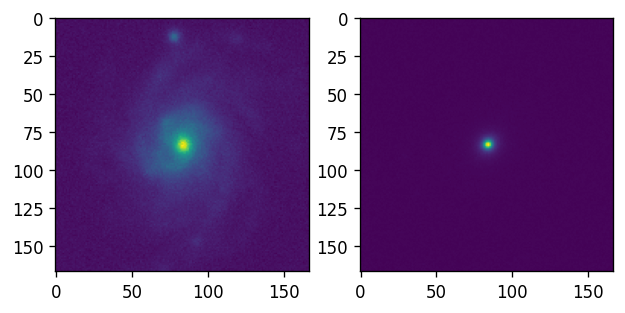

In [32]:
import matplotlib as mpl
plt.figure(dpi=120)
plt.subplot(1,2,1) #setting up 1st subplot

#reading in the data and plotting the first image
img_1_data = fits.getdata("./predict_images/587722984439545906-g.fits")
plt.imshow(img_1_data)

plt.subplot(1,2,2) #setting up the 2nd subplot

#reading in the data and plotting the second image
img_2_data = fits.getdata("./predict_images/587725552281976904-g.fits")
plt.imshow(img_2_data)

## Performing Predictions with `Keras`

Now, we will be using the models trained on SDSS simulations and real data from the paper in order to perform predictions on the two above images. 

In [33]:
from gamornet.keras_module import gamornet_predict_keras

#Adding an explicit third axis to the image data (as this is needed for
#the GaMorNet function to work properly). Just to be clear the images
#were already 167*167, so we are not resizing the X,Y dimensions in any
#way
img_1_data = np.reshape(img_1_data,newshape=(167,167,1))
img_2_data = np.reshape(img_2_data,newshape=(167,167,1))
img_array = np.array([img_1_data,img_2_data])

#Performing Predictions
predictions = gamornet_predict_keras(img_array, model_load_path='SDSS_tl', input_shape='SDSS', batch_size=64)

Loading GaMorNet Model.....
Fetching SDSS TL Weigths.....
Performing Predictions.....


The `model_load_path = 'SDSS_tl'` is a special parameter value which automatically downloads and uses the final SDSS model of the paper. The `input_shape` parameter specifies the shape of the input images. Setting this to `SDSS` automatically sets the value to `(167,167,1)`

 For an explanation of each of the arguments of `gamornet_predict_keras`, please have a look at the [API Documentation](https://gamornet.readthedocs.io/en/latest/api_docs.html)

## Understanding the Predictions Made By `Keras`

In [34]:
predictions.shape

(2, 3)

As the above command shows, the returned predictions array is of the shape (# of images, 3) where for each image we have one single-dimensional array with 3 elements where

* Element 0 is the probability for the image to be *disk-dominated*
* Element 1 is the probability for the image to be *indeterminate*
* Element 2 is the probability for the image to be *bulge-dominated*

In [39]:
#1st image predictions 
print(predictions[0])

#2nd image predictions
print(predictions[1])

[9.9598134e-01 3.9425851e-03 7.6107666e-05]
[5.2933254e-05 6.2009869e-03 9.9374604e-01]


As can be seen from the above arrays, GaMorNet predicts with 99.6% confidence that the first image is a disk-dominated galaxy and with 99.37% confidence that the second image is a bulge-dominated galaxy. 

These are indeed correct predictions as can be verified by investigating the light profiles of the galaxies in detail. 

*Tip: The number in the name of each image file refers to their SDSS Object ID*

***

#### Q - Reflect on the predictions you made earlier regarding applications for machine learning in astronomy. Where and why might it be advantageous to use neural networks to process astronomical data? Why, in particular, might it be useful in the context of galaxy studies?

***

Ans. Here

That's it for today's tutorial! Congrats on making it all the way through to the end of our Python in Astronomy workshop!